<>:179: SyntaxWarning: invalid escape sequence '\s'
<>:189: SyntaxWarning: invalid escape sequence '\s'
<>:179: SyntaxWarning: invalid escape sequence '\s'
<>:189: SyntaxWarning: invalid escape sequence '\s'
C:\Users\soura\AppData\Local\Temp\ipykernel_7740\2780393001.py:179: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Fully connected graph with RBF kernel ($\sigma=0.01$)')
C:\Users\soura\AppData\Local\Temp\ipykernel_7740\2780393001.py:189: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Fully connected graph with RBF kernel ($\sigma=0.01$) Chebyshev Davidson')
C:\Users\soura\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\soura\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory l

Mat-Mat 304
Vec-Vec 2
Mat-Vec 2435


C:\Users\soura\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


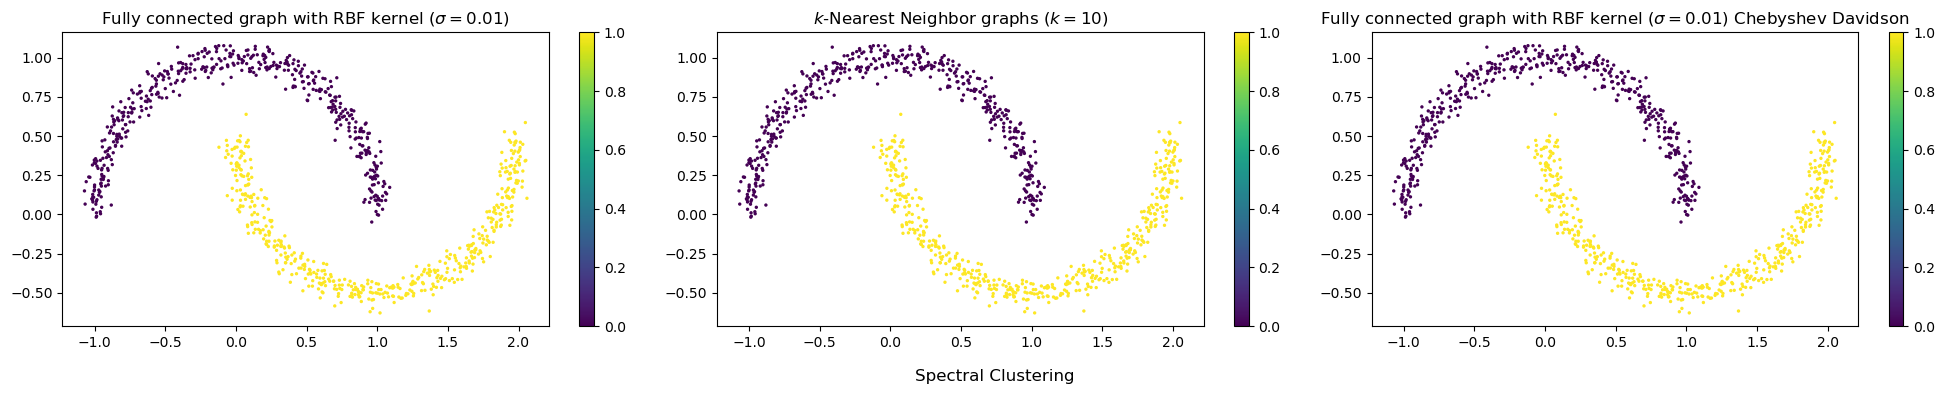

In [1]:
# # Adapted from  https://github.com/zhangyk8/Spectral-Clustering/blob/master/spectral_clustering.py
########################################

from sklearn import datasets
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
import gzip


import chebDev

def writeMatrix(mat, filename):
    with open(filename,'wt') as f:
        for i in range(mat.shape[0]):
            f.write(','.join([str(a) for a in mat[i,:]])+'\n')

    
def checkHermitian(mat, name):
    for i in range(mat.shape[0]):
        for j in range(i, mat.shape[1]):
            if mat[i, j] != mat[j, i] and (abs(mat[i,j])>1e-14 and abs(mat[j,i])>1e-14):
                print(name,'not hermitian', i,j, mat[i,j], mat[j,i])
                raise ValueError("Matrix Not Hermitian")

def maskFloatErr(mat, tol = 1e-14):
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if abs(mat[i,j]) < 1e-14:
                mat[i,j]=0
    return mat

def makeHermitianIfBelowFloatErr(mat, tol = 1e-14):
    for i in range(mat.shape[0]):
        for j in range(i, mat.shape[1]):
            if mat[i, j] != mat[j, i]:
                if abs(mat[i,j]) < 1e-14 and abs(mat[j,i]) < 1e-14:
                    mat[i,j]=0
                    mat[j,i]=0
                else:
                    print('not hermitian', i,j, mat[i,j], mat[j,i])
                    raise ValueError("Matrix Not Hermitian")
    return mat


def getEig(mat, eig_algo, k=None):
    if eig_algo == 'np_linalg':
        return np.linalg.eig(mat)
    elif eig_algo == 'cheb_dav':
        #mat = makeHermitianIfBelowFloatErr(mat)
        #checkHermitian(mat,'cheb_dav')
        val, vec, matmat, vecvec, matvec = chebDev.cheb_dav(mat,k)
        print('Mat-Mat',matmat)
        print('Vec-Vec',vecvec)
        print('Mat-Vec',matvec)
        return val, np.asarray(vec)
    else:
        raise Exception ("Invalid Eigen-Algorithm choice. Must be 'np_linalg' or 'cheb_dav'")

# Based on "A Tutorial on Spectral Clustering" written by Ulrike von Luxburg
def Spectral_Clustering(X, K=8, adj=True, metric='euclidean', sim_graph='fully_connect', sigma=1, knn=10, epsi=0.5, normalized=1, eig_algo='np_linalg'):
    '''
    Input: 
        X : [n_samples, n_samples] numpy array if adj=True, or, a [n_samples_a, n_features] array otherwise;
        K: int, The number of clusters;
        adj: boolean, Indicating whether the adjacency matrix is pre-computed. Default: True;
        metric: string, A parameter passing to "scipy.spatial.distance.pdist()" function for computing the adjacency matrix (deprecated if adj=True). Default: 'euclidean';
        sim_graph: string, Specifying the type of similarity graphs. Choices are ['fully_connect', 'eps_neighbor', 'knn', 'mutual_knn']. Default: 'fully_connect';
        sigma: float, The variance for the Gaussian (aka RBF) kernel (Used when sim_graph='fully_connect'). Default: 1;
        knn: int, The number of neighbors used to construct k-Nearest Neighbor graphs (Used when sim_graph='knn' or 'mutual_knn'). Default: 10;
        epsi: float, A parameter controlling the connections between points (Used when sim_graph='eps_neighbor'). Default: 0.5;
        normalized: int, 1: Random Walk normalized version; 2: Graph cut normalized version; other integer values: Unnormalized version. Default: 1.
    Output:
        sklearn.cluster class, Attributes:
            cluster_centers_ : array, [n_clusters, n_features], Coordinates of cluster centers in K-means;
            labels_ : Labels of each point;
            inertia_ : float, Sum of squared distances of samples to their closest cluster center in K-means;
            n_iter_ : int, Number of iterations run in K-means.
    '''
    # Compute the adjacency matrix
    if not adj:
        Adj_mat = squareform(pdist(X, metric=metric))
    else:
        Adj_mat = X
    # Compute the weighted adjacency matrix based on the type of similarity graphs
    if sim_graph ==  'fully_connect':
        W = np.exp(-Adj_mat/(2*sigma))
    elif sim_graph == 'eps_neighbor':
        W = (Adj_mat <= epsi).astype('float64')
    elif sim_graph == 'knn':
        W = np.zeros(Adj_mat.shape)
        # Sort the adjacency matrx by rows and record the indices
        Adj_sort = np.argsort(Adj_mat, axis=1)
        # Set the weight (i,j) to 1 when either i or j is within the k-nearest neighbors of each other
        for i in range(Adj_sort.shape[0]):
            W[i,Adj_sort[i,:][:(knn+1)]] = 1
    elif sim_graph == 'mutual_knn':
        W1 = np.zeros(Adj_mat.shape)
        # Sort the adjacency matrx by rows and record the indices
        Adj_sort = np.argsort(Adj_mat, axis=1)
        # Set the weight W1[i,j] to 0.5 when either i or j is within the k-nearest neighbors of each other (Flag)
        # Set the weight W1[i,j] to 1 when both i and j are within the k-nearest neighbors of each other
        for i in range(Adj_mat.shape[0]):
            for j in Adj_sort[i,:][:(knn+1)]:
                if i == j:
                    W1[i,i] = 1
                elif W1[i,j] == 0 and W1[j,i] == 0:
                    W1[i,j] = 0.5
                else:
                    W1[i,j] = W1[j,i] = 1
        W = np.copy((W1 > 0.5).astype('float64'))
    elif sim_graph == 'raw': #Use adjacency matrix as affinity matrix
        W = Adj_mat
    else:
        raise ValueError("The 'sim_graph' argument should be one of the strings, 'fully_connect', 'eps_neighbor', 'knn', or 'mutual_knn'!")
        
    # Compute the degree matrix and the unnormalized graph Laplacian
    D = np.diag(np.sum(W, axis=1))
    L = D - W
    checkHermitian(W,'W')
    checkHermitian(D,'D')
    checkHermitian(L,'L')
    # Compute the matrix with the first K eigenvectors as columns based on the normalized type of L
    if normalized == 1:   ## Random Walk normalized version
        # Compute the inverse of the diagonal matrix
        D_inv = np.diag(1/np.diag(D))
        # Compute the eigenpairs of L_{rw}
        mat = np.dot(D_inv, L)
        #checkHermitian(mat,'L_rw')
        #mat = makeHermitianIfBelowFloatErr(mat)
        writeMatrix(W, 'W.mat')
        #checkHermitian(mat,'L_rw')

        Lambdas, V = getEig(mat, eig_algo, k=K)
        # Sort the eigenvalues by their L2 norms and record the indices
        ind = np.argsort(np.linalg.norm(np.reshape(Lambdas, (1, len(Lambdas))), axis=0))
        V_K = np.real(V[:, ind[:K]])
    elif normalized == 2:   ## Graph cut normalized version
        # Compute the square root of the inverse of the diagonal matrix
        D_inv_sqrt = np.diag(1/np.sqrt(np.diag(D)))
        # Compute the eigenpairs of L_{sym}
        Lambdas, V = getEig(np.matmul(np.matmul(D_inv_sqrt, L), D_inv_sqrt), eig_algo, k=K)
        # Sort the eigenvalues by their L2 norms and record the indices
        ind = np.argsort(np.linalg.norm(np.reshape(Lambdas, (1, len(Lambdas))), axis=0))
        V_K = np.real(V[:, ind[:K]])
        if any(V_K.sum(axis=1) == 0):
            raise ValueError("Can't normalize the matrix with the first K eigenvectors as columns! Perhaps the number of clusters K or the number of neighbors in k-NN is too small.")
        # Normalize the row sums to have norm 1
        V_K = V_K/np.reshape(np.linalg.norm(V_K, axis=1), (V_K.shape[0], 1))
    else:   ## Unnormalized version
        # Compute the eigenpairs of L
        Lambdas, V = getEig(L, eig_algo, k=K)
        # Sort the eigenvalues by their L2 norms and record the indices
        ind = np.argsort(np.linalg.norm(np.reshape(Lambdas, (1, len(Lambdas))), axis=0))
        V_K = np.real(V[:, ind[:K]])
        
    # Conduct K-Means on the matrix with the first K eigenvectors as columns
    kmeans = KMeans(n_clusters=K, init='k-means++', random_state=0).fit(V_K)
    return kmeans


def main():
    # Generate a toy dataset...
    moon_data, moon_labels = datasets.make_moons(1000, noise=0.05)
    # Compute the adjacency matrix
    Adj_mat = squareform(pdist(moon_data, metric='euclidean'))
    # Spectral clustering...
    spec_re1 = Spectral_Clustering(Adj_mat, K=2, sim_graph='fully_connect', sigma=0.01, normalized=0)
    spec_re2 = Spectral_Clustering(Adj_mat, K=2, sim_graph='knn', knn=10, normalized=1)
    spec_re3 = Spectral_Clustering(Adj_mat, K=2, sim_graph='fully_connect', sigma=0.01, normalized=2, eig_algo='cheb_dav')

    # Often need to change figsize when doing subplots
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 3, 1)
    plt.scatter(x=moon_data[:, 0], y=moon_data[:, 1], c=spec_re1.labels_, s=2)
    plt.colorbar()
    plt.title('Fully connected graph with RBF kernel ($\sigma=0.01$)')

    plt.subplot(1, 3, 2)
    plt.scatter(x=moon_data[:, 0], y=moon_data[:, 1], c=spec_re2.labels_, s=2)
    plt.colorbar()
    plt.title('$k$-Nearest Neighbor graphs ($k=10$)')

    plt.subplot(1, 3, 3)
    plt.scatter(x=moon_data[:, 0], y=moon_data[:, 1], c=spec_re3.labels_, s=2)
    plt.colorbar()
    plt.title('Fully connected graph with RBF kernel ($\sigma=0.01$) Chebyshev Davidson')

    plt.suptitle('Spectral Clustering', y=-0.01)

    # Automatrically adjust padding between subpots 
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    main()    

In [2]:

def cut(adj_matrix, cluster, rest_of_graph):
    """
    Compute the cut between a cluster and the rest of the graph.
    """
    cut_value = 0
    for i in cluster:
        for j in rest_of_graph:
            cut_value += adj_matrix[i][j]
    return cut_value/2

def volume(adj_matrix, cluster):
    """
    Compute the volume of a cluster.
    """
    vol_value = 0
    for i in cluster:
        vol_value += np.sum(adj_matrix[i])
    return vol_value

def ratio_cut(adj_matrix, clusters):
    """
    Compute the RatioCut of a graph partitioning.
    
    Parameters:
    adj_matrix : numpy.ndarray
        Adjacency matrix of the graph (nxn).
    clusters : list of lists
        List containing k clusters, each cluster is a list of node indices.
        
    Returns:
    float
        The RatioCut value.
    """
    ratio_cut_value = 0
    n = adj_matrix.shape[0]
    
    for cluster in clusters:
        rest_of_graph = list(set(range(n)) - set(cluster))
        cut_value = cut(adj_matrix, cluster, rest_of_graph)
        ratio_cut_value += cut_value / len(cluster)
    
    return ratio_cut_value


def ncut(adj_matrix, clusters):
    """
    Compute the Normalized Cut (NCut) of a graph partitioning.
    
    Parameters:
    adj_matrix : numpy.ndarray
        Adjacency matrix of the graph (nxn).
    clusters : list of lists
        List containing k clusters, each cluster is a list of node indices.
        
    Returns:
    float
        The NCut value.
    """


    ncut_value = 0
    n = adj_matrix.shape[0]

    for cluster in clusters:
        rest_of_graph = list(set(range(n)) - set(cluster))
        cut_value = cut(adj_matrix, cluster, rest_of_graph)
        vol_value = volume(adj_matrix, cluster)
        ncut_value += cut_value / vol_value
    
    return ncut_value





Mat-Mat 290
Vec-Vec 2
Mat-Vec 2321


C:\Users\soura\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Mat-Mat 466
Vec-Vec 2
Mat-Vec 3731


C:\Users\soura\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


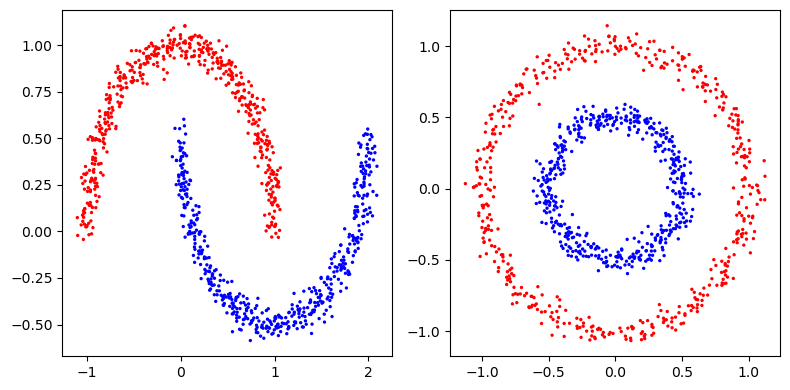

In [3]:
    moon_data, moon_labels = datasets.make_moons(1000, noise=0.05)
    circles_data, circles_labels = datasets.make_circles(n_samples=1000, noise=0.05, factor=0.5)

    # Compute the adjacency matrix
    Adj_mat1 = squareform(pdist(moon_data, metric='euclidean'))
    Adj_mat2 = squareform(pdist(circles_data, metric='euclidean'))

    # Spectral clustering...
    spec_re1 = Spectral_Clustering(Adj_mat1, K=2, sim_graph='fully_connect', sigma=0.01, normalized=2, eig_algo='cheb_dav')
    spec_re2 = Spectral_Clustering(Adj_mat2, K=2, sim_graph='fully_connect', sigma=0.01, normalized=2, eig_algo='cheb_dav')

    # Often need to change figsize when doing subplots
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(x=moon_data[:, 0], y=moon_data[:, 1], c=spec_re1.labels_, s=2, cmap='bwr')


    plt.subplot(1, 2, 2)
    plt.scatter(x=circles_data[:, 0], y=circles_data[:, 1], c=spec_re2.labels_, s=2, cmap='bwr')


    # Automatrically adjust padding between subplots 
    plt.tight_layout()
    #plt.savefig("../../Reports/tex/toyexmples.png")
    plt.show()


In [4]:
from networkx.generators.community import LFR_benchmark_graph
import networkx as nx
import umap

n = 2500
tau1 = 3
tau2 = 1.8
mu = 0.03
G = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=5, min_community=100, seed=10
)
print(G)

Graph with 2500 nodes and 5409 edges


In [5]:
mat = nx.adjacency_matrix(G).todense()
for i in range(mat.shape[0]):
    mat[i][i]=0

In [6]:
k=15
print('K=',k)
spec_re1 = Spectral_Clustering(mat, K=k, sim_graph='fully_connect', sigma=0.01, normalized=2)
clusters = []
for c in set(spec_re1.labels_):
    cluster = [i for i,a in enumerate(spec_re1.labels_) if a==c]
    clusters.append(cluster)


print("Ratio Cut:",ratio_cut(mat, clusters))

print("N Cut:",ncut(mat, clusters))


K= 15
Ratio Cut: 26.102440171274292
N Cut: 5.55197111135766


C:\Users\soura\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


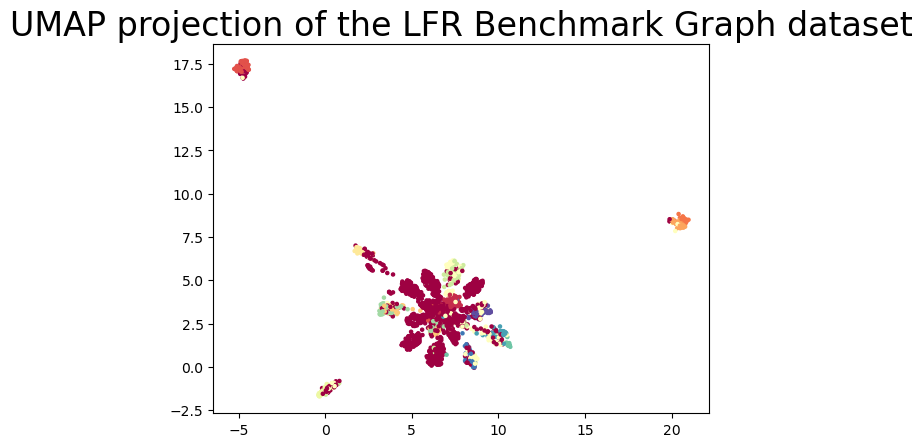

In [7]:
reducer = umap.UMAP(random_state=42)
reducer.fit(mat)
embedding = reducer.transform(mat)
plt.scatter(embedding[:, 0], embedding[:, 1], c=spec_re1.labels_, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the LFR Benchmark Graph dataset', fontsize=24);


Mat-Mat 26
Vec-Vec 2
Mat-Vec 209


C:\Users\soura\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


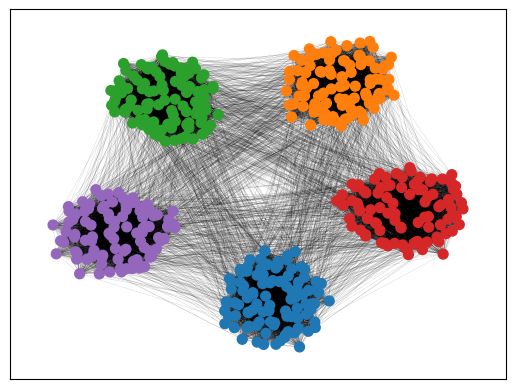

In [10]:

G_gaussian = nx.gaussian_random_partition_graph(n=500, s=100, v=10, p_in=0.98, p_out=0.02)
mat = nx.adjacency_matrix(G_gaussian).todense()
for i in range(mat.shape[0]):
    mat[i][i]=0

spec_gaussian = Spectral_Clustering(mat, K=5, metric='euclidean', sim_graph='raw', eig_algo='cheb_dav', normalized=2)
colorDict = plt.get_cmap('tab10')
nx.draw_networkx(G_gaussian, node_size=50, width=0.05, with_labels=False, node_color=[colorDict.colors[c] for c in spec_gaussian.labels_])
#plt.savefig('../../Reports/tex/networkx_gaussian_clustering.png')
plt.show()

Mat-Mat 46
Vec-Vec 2
Mat-Vec 369


C:\Users\soura\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


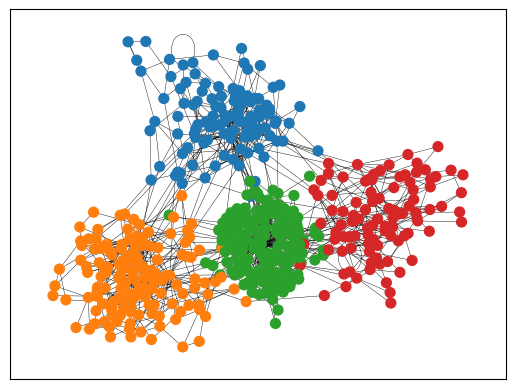

In [12]:

n = 500
tau1 = 3
tau2 = 1.5
mu = 0.1
G_LFR = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=5, min_community=60, seed=10
)

mat = nx.adjacency_matrix(G_LFR).todense()
for i in range(mat.shape[0]):
    mat[i][i]=0



spec_lfr = Spectral_Clustering(mat, K=4, metric='euclidean', sim_graph='raw', eig_algo='cheb_dav', normalized=2)
colorDict = plt.get_cmap('tab10')
nx.draw_networkx(G_LFR, node_size=50, width=0.3, with_labels=False, node_color=[colorDict.colors[c] for c in spec_lfr.labels_])
#plt.savefig('../../Reports/tex/networkx_LFR_benchmark.png')
plt.show()

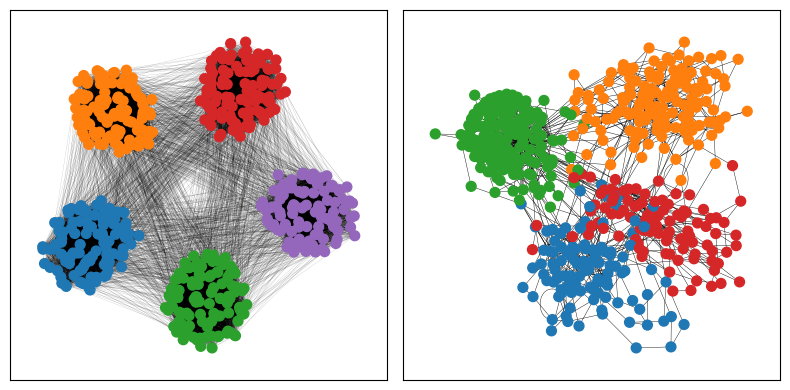

In [13]:
fig,axs = plt.subplots(1,2, figsize=(8, 4))
nx.draw_networkx(G_gaussian, node_size=50, width=0.05, with_labels=False, node_color=[colorDict.colors[c] for c in spec_gaussian.labels_], ax=axs[0])
nx.draw_networkx(G_LFR, node_size=50, width=0.3, with_labels=False, node_color=[colorDict.colors[c] for c in spec_lfr.labels_], ax=axs[1])

# Automatrically adjust padding between subplots 
plt.tight_layout()
#plt.savefig("../../Reports/tex/networkx.png")
plt.show()



In [15]:
import tarfile
import numpy as np 
import pandas as pd
from io import StringIO

tar = tarfile.open('C:/Users/soura/Downloads/__ppi_networks.1.0.2.tar.gz', 'r:gz')
for member in tar.getmembers():
     f = tar.extractfile(member)
     if f:
         content = f.read()
         Data = pd.read_csv(StringIO(content.decode('ascii')), delimiter='\t')
tar.close()
display(Data)

,INTERACTOR_A,INTERACTOR_B
0,sc20,sc2175
1,sc20,sc1070
2,sc20,sc1418
3,sc20,sc1560
4,sc20,sc700
...,...,...
164713,sc4037,sc4658
164714,sc4037,sc3475
164715,sc4037,sc4115
164716,sc4037,sc3703


In [16]:
astroPhDf = pd.read_csv('../../DataSets/SNAP/ca-AstroPh.txt.gz', compression='gzip', comment='#', delimiter='\t', names=['From','To'])
uniqueAuth = set(astroPhDf.From.to_list()+astroPhDf.To.to_list())
auth_id_map = {a:i for i,a in enumerate(sorted(uniqueAuth))}
len(auth_id_map)

18772

In [17]:
adjMat = np.zeros((len(auth_id_map), len(auth_id_map)))
for idx,row in astroPhDf.iterrows():
    from_id = auth_id_map[row['From']]
    to_id = auth_id_map[row['To']]
    adjMat[from_id][to_id] = 1
    adjMat[to_id][from_id] = 1

adjMat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
spec_astroPhy = Spectral_Clustering(adjMat, K=2, metric='euclidean', sim_graph='raw', normalized=2)

In [14]:
from collections import Counter
Counter(spec_astroPhy.labels_)

Counter({0: 18350, 1: 422})

In [15]:
import sklearn

sksc = sklearn.cluster.SpectralClustering(n_clusters=14, affinity='precomputed').fit(adjMat)
sksc.labels_

C:\Users\soura\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


array([0, 0, 0, ..., 0, 0, 0])

In [16]:
Counter(sksc.labels_)

Counter({0: 18346,
         6: 67,
         11: 60,
         12: 57,
         13: 42,
         3: 37,
         4: 36,
         5: 34,
         9: 29,
         7: 23,
         2: 23,
         10: 7,
         8: 7,
         1: 4})

In [23]:
!pip install pynndescent==0.5.13

   ---------------------------------------- 0.0/56.9 kB ? eta -:--:--
   ------- -------------------------------- 10.2/56.9 kB ? eta -:--:--
   ---------------------------------------- 56.9/56.9 kB 1.0 MB/s eta 0:00:00
  Attempting uninstall: pynndescent
    Found existing installation: pynndescent 0.5.10
    Uninstalling pynndescent-0.5.10:
      Successfully uninstalled pynndescent-0.5.10


C:\Users\soura\anaconda3\Lib\site-packages\umap\spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


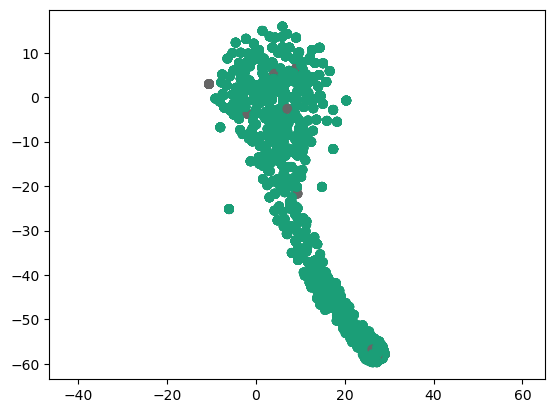

In [15]:
import umap
reducer = umap.UMAP()
#embedding = reducer.fit_transform(adjMat)
reducer.fit(adjMat)
embedding = reducer.transform(adjMat)

plt.scatter(embedding[:, 0], embedding[:, 1], c=spec_astroPhy.labels_, cmap='Dark2')
plt.gca().set_aspect('equal', 'datalim')



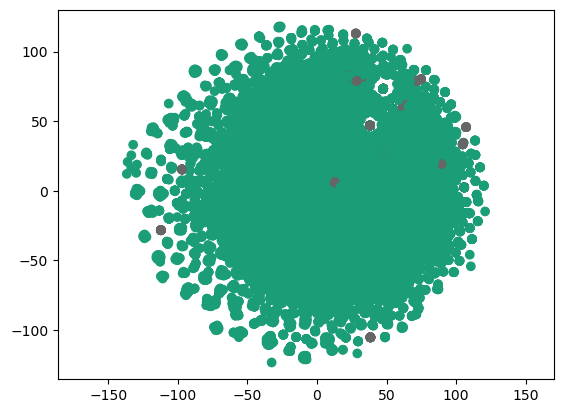

In [17]:
from sklearn.manifold import TSNE

embedding = TSNE().fit_transform(adjMat)
plt.scatter(embedding[:, 0], embedding[:, 1], c=spec_astroPhy.labels_, cmap='Dark2')
plt.gca().set_aspect('equal', 'datalim')


In [21]:
uniqueNodes = set()
connectDict = 
with gzip.open('../../DataSets/SNAP/com-amazon.top5000.cmty.txt.gz') as amz:
    

amztop5k = pd.read_csv('../../DataSets/SNAP/com-amazon.top5000.cmty.txt.gz', compression='gzip', comment='#')
amztop5k

,164985\t225214\t232761
0,105089\t282815\t331787
1,167906\t288975\t421279\t442612\t451312
2,69880\t231953\t518997\t523128
3,135499\t160294\t304770
4,112813\t112814\t112821\t112823
...,...
4994,231176\t357878\t372935
4995,169423\t465191\t528417
4996,54847\t82457\t492247
4997,12785\t27959\t82924


In [19]:


!conda list

# packages in environment at C:\Users\soura\anaconda3:
#
# Name                    Version                   Build  Channel
_anaconda_depends         2024.06             py312_mkl_2  
abseil-cpp                20211102.0           hd77b12b_0  
aiobotocore               2.12.3          py312haa95532_0  
aiohttp                   3.9.5           py312h2bbff1b_0  
aioitertools              0.7.1              pyhd3eb1b0_0  
aiosignal                 1.2.0              pyhd3eb1b0_0  
alabaster                 0.7.16          py312haa95532_0  
altair                    5.0.1           py312haa95532_0  
anaconda-anon-usage       0.4.4           py312hfc23b7f_100  
anaconda-catalogs         0.2.0           py312haa95532_1  
anaconda-client           1.12.3          py312haa95532_0  
anaconda-cloud-auth       0.5.1           py312haa95532_0  
anaconda-navigator        2.6.0           py312haa95532_0  
anaconda-project          0.11.1          py312haa95532_0  
annotated-types           0.6.0   